In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mpl_defaults
from mpl_defaults import autoscale_y
import matplotlib as mpl
import matplotlib.transforms as transform
import scipy
import normal_He3_params as he3
import seaborn as sns
idx = pd.IndexSlice
from numpy.fft import fft 


%matplotlib inline

In [2]:
def d2dx2(num, dx):
    mat = np.zeros((num+1, num+1))
    for i in range(num):
        mat[i, i] = -2
        try:
            mat[i, i-1] = 1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx**2

def ddx(num, dx):
    mat = np.zeros((num+1, num+1))
    for i in range(num):
        try:
            mat[i, i-1] = -1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx

def psi(vecs, En, x):
    df= pd.concat([component_df(vecs, En, i, x) for i in np.arange(4)], axis = 1).T.sort_index().T
    return df

def component_df(vecs:np.array, En, component:int, x:np.array) -> pd.DataFrame:
    start = component*len(En)//4
    stop = (component+1)*len(En)//4

    pos_E = En[En>=0]
    neg_E = En[En<0]


    # particle_high_idx = np.where(En == pos_E[-1])[0][0]
    # hole_high_idx = np.where(En == neg_E[0])[0][0]

    # data = vecs[start:stop, hole_high_idx:particle_high_idx+1]
    data = vecs[start:stop, :]

    En_index = np.concatenate( [
        np.flip(np.arange(len(neg_E))*-1)-1,
        np.arange(len(pos_E))+1,
        ])
    df = pd.DataFrame(
        data, 
        index = x,
        columns = pd.MultiIndex.from_product([
            En_index,
            [f'c_{component}'],
        ])
    )

    df.columns.rename('En', level = 0, inplace = True)
    df.columns.rename(f'c_i', level = 1, inplace = True)
    df.index.rename('x', inplace = True)
    return df


def gap_spatial_perp(z, l = 10, strech = 1):
    return np.where(z<l/2, np.tanh(strech*z), np.tanh(strech*(z-l))*-1)
    # if z < l/2: return np.tanh(z)
    # else: return np.tanh(z-10)*-1

def pandas_fft(data) -> pd.Series:
    return pd.DataFrame(
        data = fft(data),
        index = data.index
    )


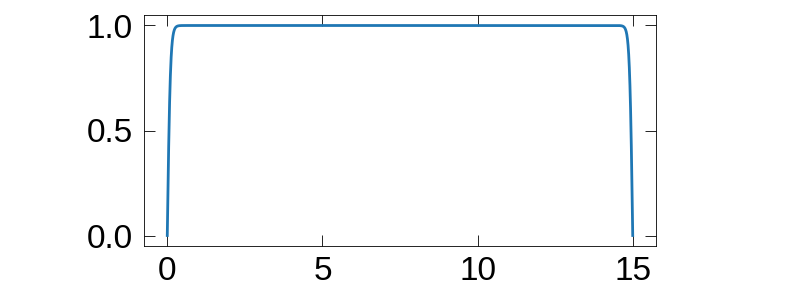

In [3]:
P = 29.3

channel_height = 1.1E-6
coherence_length = he3.v_Fermi(P)*he3.hbar/(2*np.pi*he3.kb*he3.Tc_line(P)*1E-3)

# z_real = np.linspace(0, 15, 2000)
# dz = z[1]-z[0]

dz = 1E-2/2
zmin = 0
zmax = 15
z_real = np.arange(zmin, zmax+dz, dz)
z = z_real
# z = z_real/z_real.max()*channel_height/coherence_length

# gap_spatial_dep = np.tanh(z*10)
gap_spatial_dep = gap_spatial_perp(z, l = z.max()-z.min(), strech= 10)
# gap_spatial_dep = np.tanh(z)
tanh_mat = np.zeros((len(z), len(z)))
np.fill_diagonal(tanh_mat, gap_spatial_dep)

fig, ax = plt.subplots(figsize = (8, 3))
ax.plot(z, gap_spatial_dep)

# BdG equation

In [4]:
gam = 1.76

energy_scale = he3.Tc_line(P)*1E-3/he3.T_Fermi(P) #Tc/Tf
alpha = np.pi**2/gam *  energy_scale
beta= np.pi/(1j)*energy_scale
kappa = energy_scale**-1/gam #Tf/Tc



K = -1*alpha*d2dx2(len(z), dz) - kappa*np.identity(n = len(z))


U = beta * np.matmul(tanh_mat, ddx(len(z), dz))

mat0 = np.zeros((len(z), len(z)))
H = np.block([
    [K, mat0, mat0, U],
    [mat0, K, U, mat0], 
    [mat0, np.conjugate(U).T, -K, mat0],
    [np.conjugate(U).T, mat0, mat0, -K]
]) 

# subtract off the fermi energy
# H = H+kappa*np.identity(n = H.shape[0])

eigval, eigvec = np.linalg.eigh(H)
E = eigval
pos_E = E[E>0]
neg_E = E[E<0]
psi_df = psi(eigvec, E, z)


: 

: 

The coefficient on the kinetic energy operator
$$
\alpha = \frac{\pi^2}{4} \frac{1.76T_c}{T_F} 
$$

The coefficient on the pair potential: 
$$
\beta = \frac{\pi}{2i}\frac{1.76T_c}{T_F}
$$

The chemical potential:
$$
\kappa = \frac{\mu}{\Delta_0}
 =\frac{T_F}{1.76T_c}
$$

$$
K = -\alpha \frac{\partial^2}{\partial z^2} - \kappa
$$

$$
U = \beta\tanh(z/\zeta_0) \frac{\partial}{\partial z}
$$

This makes the eigenvalues
$$
\lambda_n = \frac{E_n}{\Delta_0}
$$

I think my bound states are the eigenvalues centered around 0, no need for subtracting $E_F$

Text(0.5, 0, 'eigenvalues')

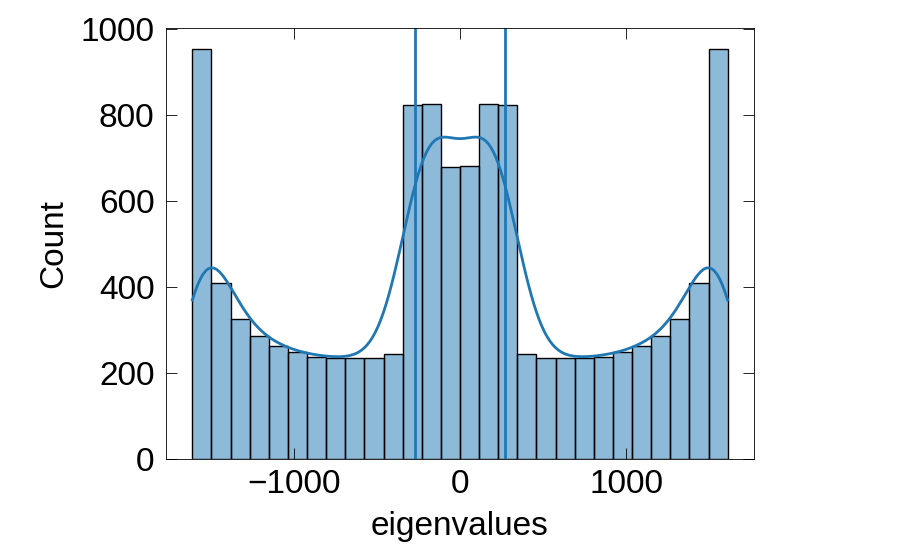

In [ ]:
fig, ax = plt.subplots()
sns.histplot(x=eigval, kde = True, ax=ax)
ax.axvline(kappa)
ax.axvline(-kappa)
ax.set_xlabel('eigenvalues')

In [ ]:
# particle_gs_idx = np.where(E==pos_E[0])[0][0]
# hole_gs_idx = np.where(E == neg_E[-1])[0][0]

# particle_gs_idx

# particle_high_idx = np.where(E==pos_E[-1])[0][0]
# hole_high_idx = np.where(E == neg_E[0])[0][0]

# print(particle_high_idx, hole_high_idx)
# len(E)
# len(E[hole_high_idx: particle_high_idx +1])

# def psi(vecs, x, gs_idx):
#     df= pd.concat([component_df(vecs, i, x, gs_idx) for i in np.arange(4)], axis = 1).T.sort_index().T
#     return df

# def component_df(vecs:np.array, component:int, x:np.array, gs_idx:int) -> pd.DataFrame:
#     start = component*len(eigvec)//4
#     stop = (component+1)*len(eigvec)//4
#     df = pd.DataFrame(
#         vecs[start:stop, gs_idx:], 
#         index = x,
#         columns = pd.MultiIndex.from_product([
#             np.arange(vecs[:, gs_idx:].shape[1]),
#             [f'c_{component}'],
#         ])
#     )

#     df.columns.rename('En', level = 0, inplace = True)
#     df.columns.rename(f'c_i', level = 1, inplace = True)
#     df.index.rename('x', inplace = True)
#     return df


In [ ]:
pdf =psi_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T


psi_fft =psi_df.T.groupby('En', group_keys = False).apply(pandas_fft).T
k = np.fft.fftfreq(len(psi_fft))*len(psi_fft)/((z.max()-z.min()))*(2*np.pi)
p = k*(np.pi * energy_scale)
psi_fft.set_index(k, inplace = True)
psi_fft.index.name = 'k'
psi_fft

psi_modes = psi_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T
psi_modes.index.name = 'k'
psi_modes


En,-6000,-5999,-5998,-5997,-5996,-5995,-5994,-5993,-5992,-5991,...,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004
k,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000014,0.000014,2.323313e-09,2.323314e-09,0.000041,0.000041,4.646623e-09,4.646624e-09,0.000068,0.000068,...,0.000068,0.000068,2.434799e-09,2.434799e-09,0.000041,0.000041,1.217399e-09,1.217399e-09,0.000014,0.000014
0.418879,0.000014,0.000014,3.060018e-08,3.060018e-08,0.000041,0.000041,6.120042e-08,6.120042e-08,0.000068,0.000068,...,0.000068,0.000068,5.898880e-08,5.898880e-08,0.000041,0.000041,2.949437e-08,2.949436e-08,0.000014,0.000014
0.837758,0.000014,0.000014,5.887720e-08,5.887720e-08,0.000041,0.000041,1.177545e-07,1.177545e-07,0.000068,0.000068,...,0.000068,0.000068,1.155431e-07,1.155431e-07,0.000041,0.000041,5.777149e-08,5.777148e-08,0.000014,0.000014
1.256637,0.000014,0.000014,8.715452e-08,8.715452e-08,0.000041,0.000041,1.743092e-07,1.743092e-07,0.000068,0.000068,...,0.000068,0.000068,1.720980e-07,1.720980e-07,0.000041,0.000041,8.604891e-08,8.604891e-08,0.000014,0.000014
1.675516,0.000014,0.000014,1.154323e-07,1.154323e-07,0.000041,0.000041,2.308649e-07,2.308649e-07,0.000068,0.000068,...,0.000068,0.000068,2.286538e-07,2.286538e-07,0.000041,0.000041,1.143268e-07,1.143268e-07,0.000014,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.094395,0.000014,0.000014,1.437107e-07,1.437107e-07,0.000041,0.000041,2.874217e-07,2.874217e-07,0.000068,0.000068,...,0.000068,0.000068,2.852109e-07,2.852109e-07,0.000041,0.000041,1.426053e-07,1.426053e-07,0.000014,0.000014
-1.675516,0.000014,0.000014,1.154323e-07,1.154323e-07,0.000041,0.000041,2.308649e-07,2.308649e-07,0.000068,0.000068,...,0.000068,0.000068,2.286538e-07,2.286538e-07,0.000041,0.000041,1.143268e-07,1.143268e-07,0.000014,0.000014
-1.256637,0.000014,0.000014,8.715452e-08,8.715452e-08,0.000041,0.000041,1.743092e-07,1.743092e-07,0.000068,0.000068,...,0.000068,0.000068,1.720980e-07,1.720980e-07,0.000041,0.000041,8.604891e-08,8.604891e-08,0.000014,0.000014


Text(0, 0.5, '$E/\\Delta_0$')

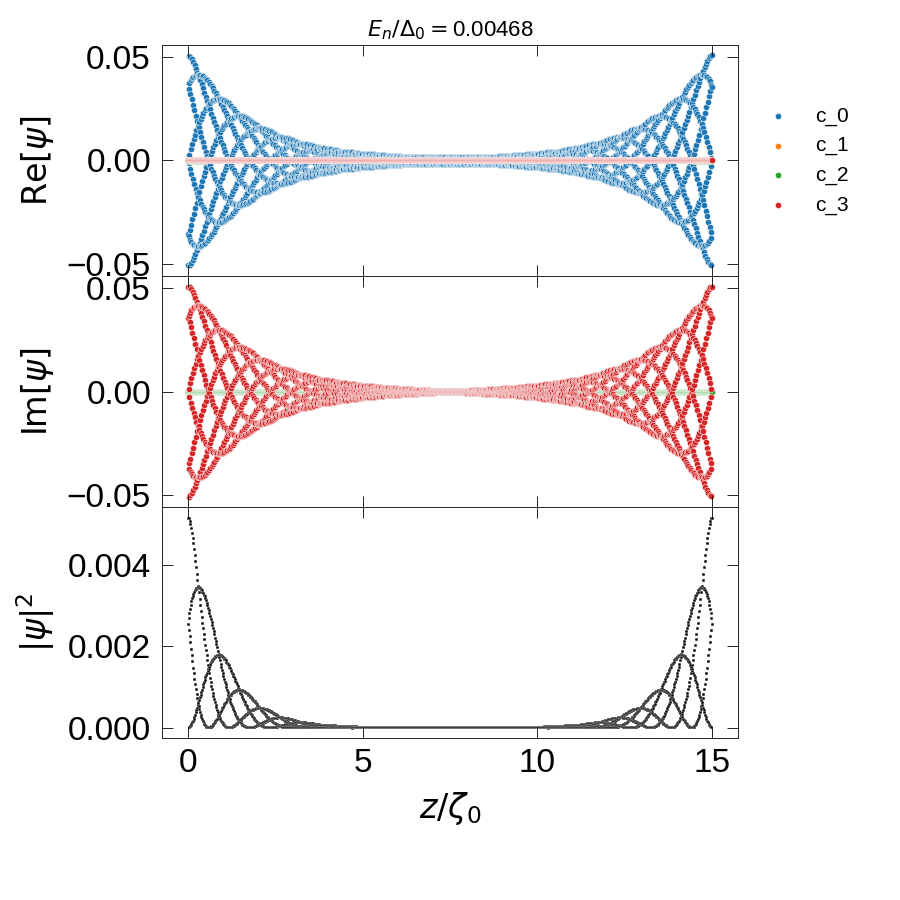

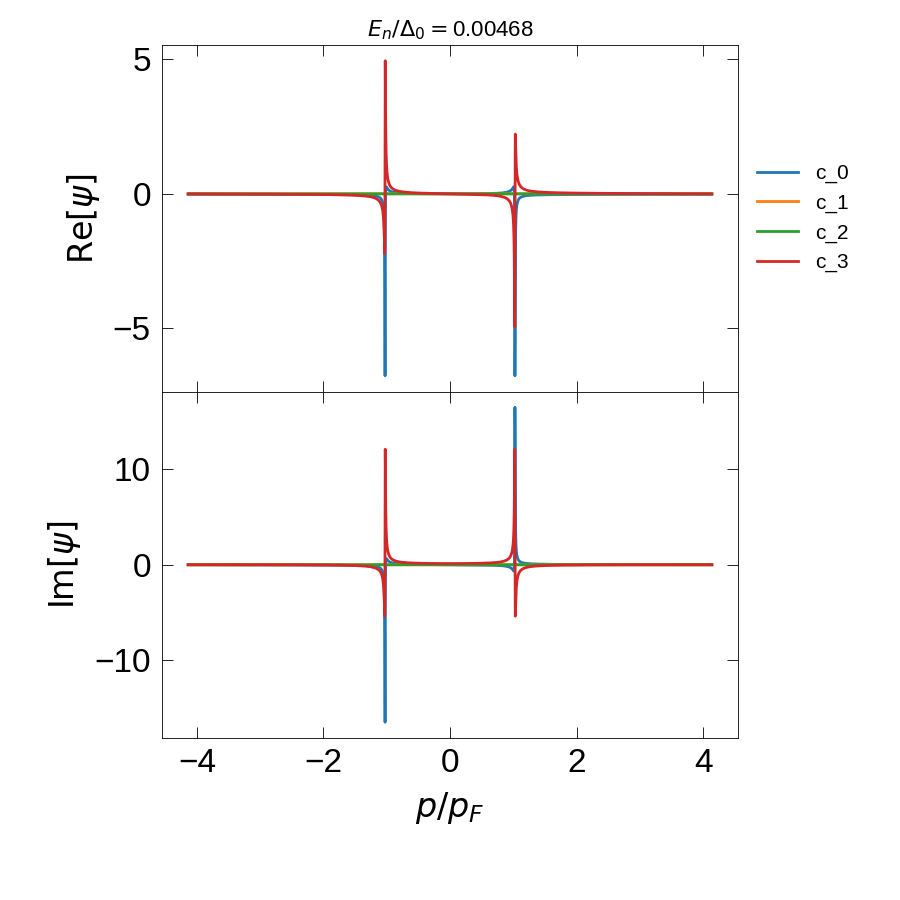

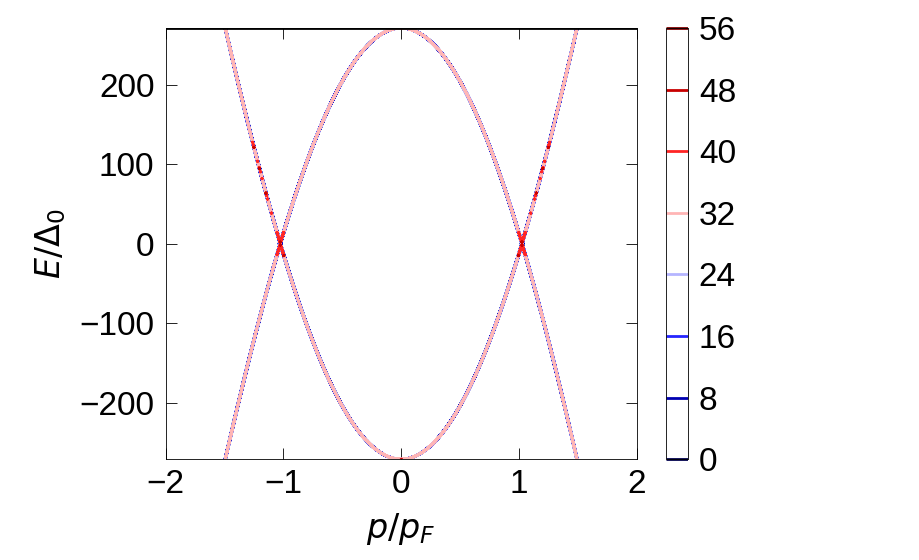

In [ ]:
i =1

data = psi_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
# fig.savefig('figures/BdG zero energy mode.pdf')



fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

fig, ax = plt.subplots()
contour = ax.contour(p, eigval, psi_modes.T, cmap = 'seismic')
cbar = fig.colorbar(contour)
ax.axhline(kappa, color='k')
ax.set_xlim(-2, 2)
ax.set_ylim(-kappa, kappa)

ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\Delta_0$')
# fig.savefig('figures/Bdg dispersion relation.pdf')
    

# Andreev equation

In [ ]:
# z= np.linspace(0, 100, 1000)
# dz = z[1]-z[0]
# tanh_mat = np.zeros((len(z), len(z)))
# gap_spatial_dep = gap_spatial_perp(z, z[-1]-z[0])
# np.fill_diagonal(tanh_mat, gap_spatial_dep)

T = ddx(len(z), dz)*2*np.pi/gam
V = np.matmul(tanh_mat, ddx(len(z), dz))*np.pi/1j * energy_scale
# mat0 = np.zeros((len(z), len(z)))
H_andreev = np.block([
    [T, mat0, mat0, V],
    [mat0, T, V, mat0],
    [mat0, np.conjugate(V).T, -1*T, mat0],
    [np.conjugate(V), mat0, mat0, -T]
])

eigval_a, eigvec_a = np.linalg.eigh(H_andreev)
E_a = eigval_a
pos_Ea = E_a[E_a>0]
neg_Ea = E_a[E_a<0]
psi_a_df = psi(eigvec_a, E_a, z)


In [ ]:
pdf_a =psi_a_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T


psi_a_fft = psi_a_df.T.groupby('En', group_keys=False).apply(pandas_fft).T
k_a = np.fft.fftfreq(len(psi_a_fft))*len(psi_a_fft)/((z.max()-z.min()))*(2*np.pi)
p_a = k_a*(np.pi * energy_scale)
psi_a_fft.set_index(k_a, inplace = True)
psi_a_fft.index.name = 'k'
psi_a_fft

psi_a_modes = psi_a_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T
psi_a_modes.index.name = 'k'
psi_a_modes


En,-6002,-6001,-6000,-5999,-5998,-5997,-5996,-5995,-5994,-5993,...,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002
k,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000014,49.328384,49.328785,0.199066,2.973004e-09,2.380467e-08,1.465144e-09,0.000001,16.442917,0.000042,...,0.001086,16.442917,0.000002,1.236812e-09,1.181840e-08,1.197141e-09,49.328383,0.000014,49.328786,0.199066
0.418879,0.000015,16.428223,16.428358,0.066305,3.768160e-06,3.873635e+01,5.252892e-03,38.736354,29.613093,0.000045,...,0.001927,29.613093,38.736320,3.769085e-06,5.102417e-02,3.873636e+01,16.428225,0.000015,16.428356,0.066305
0.837758,0.000014,3.286233,3.286260,0.013274,5.746214e-08,1.719860e-02,2.389003e-06,0.017197,21.108798,0.000045,...,0.001387,21.108798,0.017197,5.863288e-08,2.270822e-05,1.719861e-02,3.286233,0.000014,3.286260,0.013274
1.256637,0.000014,1.408423,1.408434,0.005697,8.515363e-08,9.675569e-03,1.397478e-06,0.009675,5.476128,0.000042,...,0.000390,5.476128,0.009675,8.638973e-08,1.282799e-05,9.675569e-03,1.408423,0.000014,1.408434,0.005697
1.675516,0.000014,0.782464,0.782470,0.003171,1.132926e-07,6.880672e-03,1.046905e-06,0.006881,2.688587,0.000042,...,0.000212,2.688587,0.006881,1.145231e-07,9.174872e-06,6.880672e-03,0.782464,0.000014,0.782471,0.003171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.094395,0.000014,0.497934,0.497938,0.002023,1.415035e-07,5.375608e-03,8.684785e-07,0.005376,1.625041,0.000041,...,0.000143,1.625041,0.005376,1.427395e-07,7.221160e-06,5.375608e-03,0.497934,0.000014,0.497938,0.002023
-1.675516,0.000014,0.782464,0.782470,0.003171,1.132926e-07,6.880672e-03,1.044085e-06,0.006881,2.688587,0.000042,...,0.000211,2.688587,0.006881,1.145231e-07,9.174976e-06,6.880672e-03,0.782464,0.000014,0.782471,0.003171
-1.256637,0.000014,1.408423,1.408434,0.005697,8.515363e-08,9.675569e-03,1.394375e-06,0.009675,5.476128,0.000042,...,0.000387,5.476128,0.009675,8.638973e-08,1.282804e-05,9.675569e-03,1.408423,0.000014,1.408434,0.005697


Text(0, 0.5, '$E/\\Delta_0$')

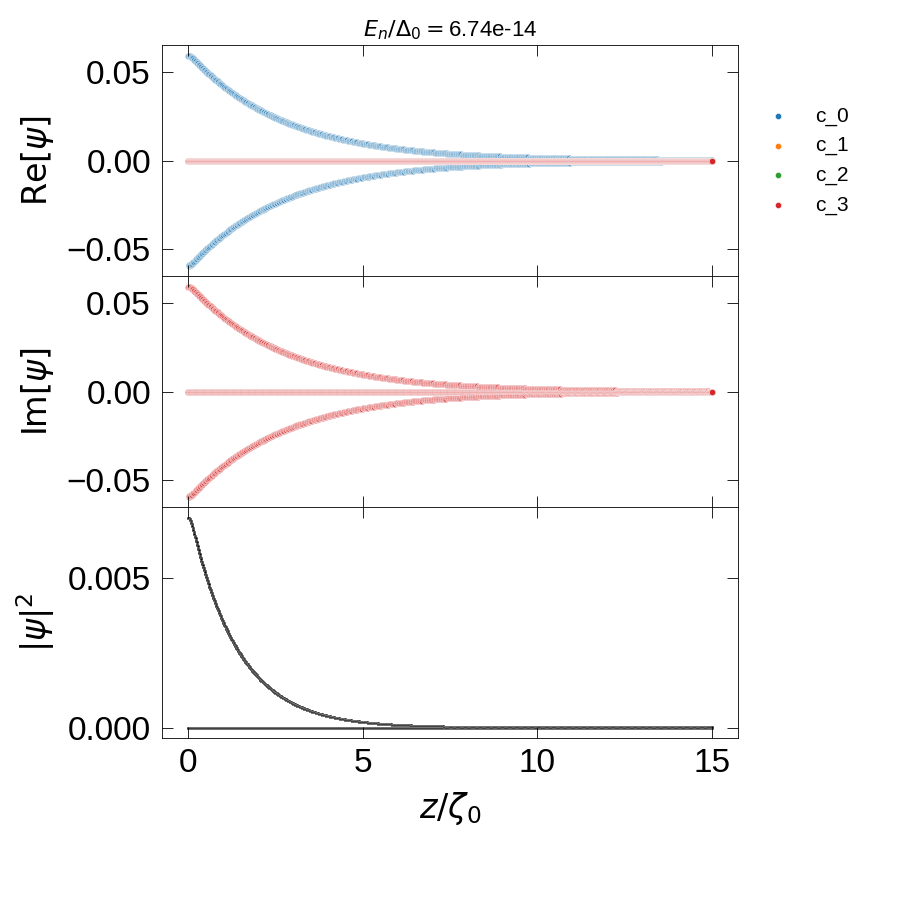

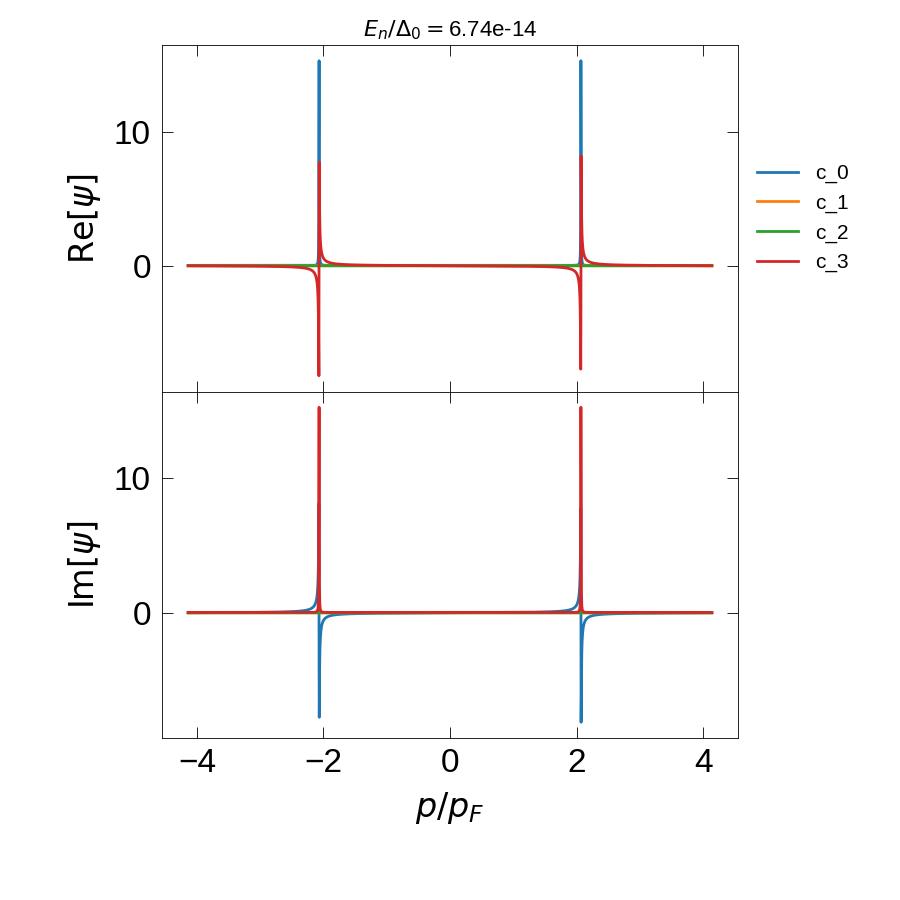

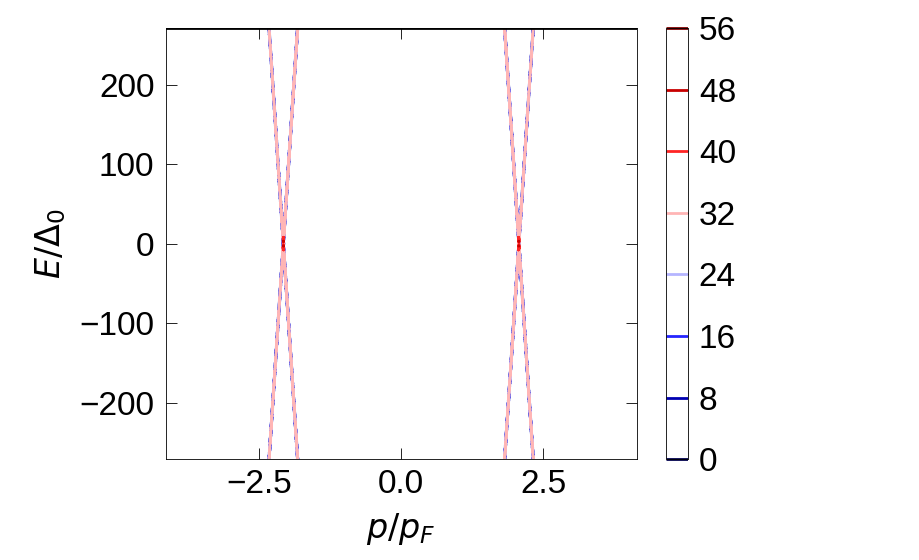

In [ ]:
i =1

data = psi_a_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf_a.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

# fig.savefig('figures/Andreev zero energy mode.pdf')


fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_a_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p_a, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p_a, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

fig, ax = plt.subplots()
contour = ax.contour(p_a, eigval_a, psi_a_modes.T, cmap = 'seismic')
cbar = fig.colorbar(contour)
ax.set_ylim(-kappa, kappa)
ax.axhline(kappa, color='k')
ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\Delta_0$')
# fig.savefig('figures/Andreev dispersion relation.pdf')
    